In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error

from src.xg_model_base import XGModel

## Extra Tree Classifier

In [2]:
model = XGModel("../data", model=ExtraTreesRegressor(n_jobs=4))
model.fit(params=dict(max_depth=20, n_estimators=10, min_samples_split=256))
model.save(Path("../models/xg_extra_trees_n10"))

In [3]:
model = XGModel("../data", model="../models/xg_extra_trees_n10")

In [4]:
zipped = zip(model.scale_dataset(model.x_train).columns, model._model.feature_importances_)
for feature, importance in sorted(zipped, key=lambda k: k[1]):
    print(feature, importance)

prev_event_type-GOAL 0.0006968485984113906
prev_event_type-PENALTY 0.001514952923428618
prev_event_type-BLOCKED_SHOT 0.0027142399729192202
prev_event_type-MISSED_SHOT 0.0032343838756261644
prev_event_type-TAKEAWAY 0.0034685441844582313
shot_type-Wrap-around 0.00405430629159219
is_home 0.004537521457846125
prev_event_type-FACEOFF 0.004866651896813097
prev_event_type-HIT 0.0049491108539285854
prev_event_type-GIVEAWAY 0.006904497561977444
prev_event_same_team 0.013164417052604136
goal_diff 0.014045158228506927
distance_change 0.014701340689274384
angle_change 0.017113074181236004
prev_event_type-SHOT 0.024190791828827298
shot_type-Slap 0.033945592473662814
shot_type-Deflected 0.03516263221575884
strength_active 0.03577587939426284
strength_opp 0.04877190725562814
shot_type-Snap 0.05369605770611331
shot_type-Backhand 0.054166748888882975
shot_type-Tip-In 0.054947377046275746
time_change 0.08205025695818335
angle 0.08349021492499266
shot_type-Wrist 0.1002511969828112
empty_net_opp 0.1279849

--> Extra Tree Regression:
train: AUC: 0.8673; RMSE: 0.2028


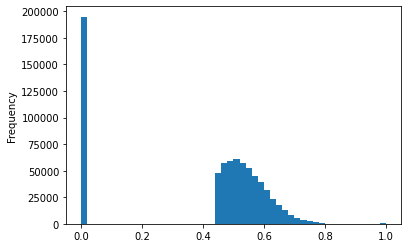

test: AUC: 0.8378; RMSE: 0.2043


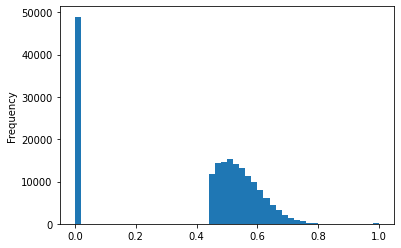

In [5]:
print("--> Extra Tree Regression:")
for ds_type in ['train', 'test']:
    print(ds_type, end=": ")
    x = model.x_train if ds_type == "train" else model.x_test
    y_true = model.y_train if ds_type == "train" else model.y_test
    y_xg = model.predict(x)

    print(f"AUC: {roc_auc_score(y_true, y_xg):.4f}; RMSE: {mean_squared_error(y_true, y_xg):.4f}")

    y_xg.plot.hist(bins=50)
    plt.show()


In [6]:
x = model.x_train[model.x_train['game_id'] == 2010020001]
y_xg = model.predict(x)
y_xg

0     0.603099
1     0.535398
2     0.000000
3     0.500603
4     0.500007
        ...   
57    0.652170
58    0.599777
59    0.573332
60    0.466735
61    0.577953
Name: xG, Length: 62, dtype: float64

## Logistic Regression

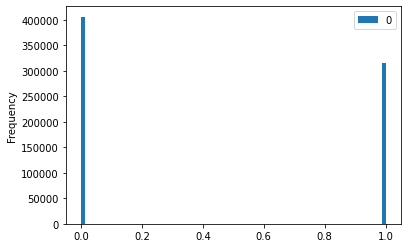

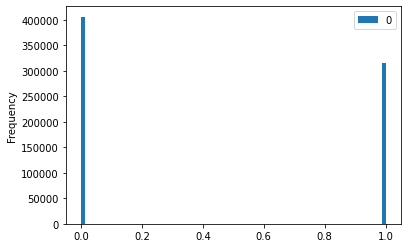

In [3]:
model = XGModel("../data", model=LogisticRegression())
model.fit(params=dict(penalty='l2', class_weight="balanced", max_iter=1000, C=0.01))

In [8]:
zipped = zip(model.x_train.columns, model._model.coef_[0])
for feature, importance in sorted(zipped, key=lambda k: k[1]):
    print(feature, importance)

strength_active -0.3107028372593936
prev_event_type-BLOCKED_SHOT -0.13623093584289847
prev_event_type-GOAL -0.08959022383430376
game_id -0.03690485507472547
angle_change -0.029232865401805065
angle -0.009942250277453579
distance_change -0.0002450585728422257
prev_event_type-HIT -2.4147744520743814e-05
prev_event_type-GIVEAWAY 0.0007057347172296577
distance 0.005800782974395301
prev_event_type-MISSED_SHOT 0.009264743087936888
shot_type-Wrist 0.013976408257116792
prev_event_same_team 0.02040719752970643
time_change 0.025902502853352306
prev_event_type-SHOT 0.04278239973628965
is_home 0.05128431421324161
goal_diff 0.05232950250051674
prev_event_type-FACEOFF 0.08995516317014933
prev_event_type-PENALTY 0.1366319530429755
strength_opp 0.3146155326896227
shot_type-Tip-In 0.5210938598839989
shot_type-Backhand 0.7226854335674748
shot_type-Snap 1.2451270384880415
empty_net_opp 1.4846891978391579
shot_type-Slap 1.8759770120236925
shot_type-Deflected 1.9079218474966555
shot_type-Wrap-around 2.9003

--> Logistic Regression:
train: AUC: 0.7630; RMSE: 0.2101


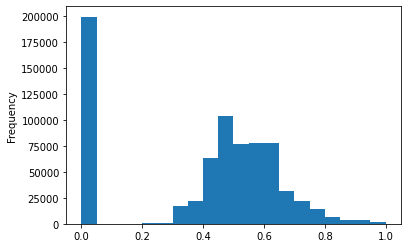

test: AUC: 0.7613; RMSE: 0.2098


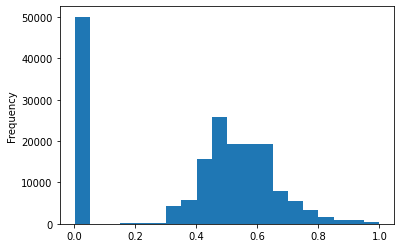

In [9]:
print("--> Logistic Regression:")
for ds_type in ['train', 'test']:
    print(ds_type, end=": ")
    x = model.x_train if ds_type == "train" else model.x_test
    y_true = model.y_train if ds_type == "train" else model.y_test
    y_xg = model.predict_xg(x)
    y_xg.index = y_true.index
    print(f"AUC: {roc_auc_score(y_true, y_xg):.4f}; RMSE: {mean_squared_error(y_true, y_xg):.4f}")
    y_xg.plot.hist(bins=20)
    plt.show()


## Neural Network

In [2]:
from src.xg_model_nn import XGModelNN
import tensorflow as tf
import seaborn as sns
import pandas as pd
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
model = XGModelNN("../data", hidden_layers="64-256-64-16-8", dropout=0.2)
history = model.fit(n_epochs=50, batch_size=256, verbose=0)

<AxesSubplot:ylabel='auc'>

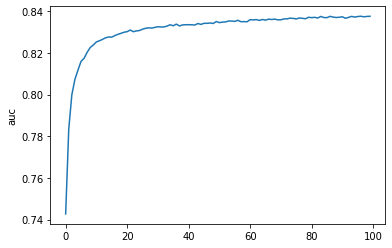

In [11]:
df_history = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=df_history, x=df_history.index, y="auc")


--> MLP:
train: AUC: 0.7090; RMSE: 0.4100


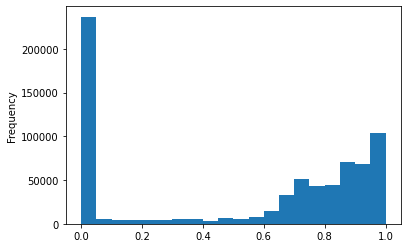

outcome    227778
0          227778
dtype: int64
test: AUC: 0.7054; RMSE: 0.4088


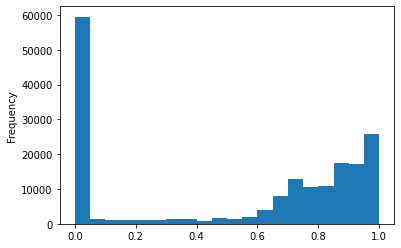

outcome    57204
0          57204
dtype: int64


In [4]:
print("--> MLP:")
for ds_type in ['train', 'test']:
    print(ds_type, end=": ")
    x = model.get_norm_train_ds() if ds_type == "train" else model.get_norm_test_ds()
    y_true = model.y_train if ds_type == "train" else model.y_test
    y_xg = model.predict_xg(x)
    y_xg.index = y_true.index
    print(f"AUC: {roc_auc_score(y_true, y_xg):.4f}; RMSE: {mean_squared_error(y_true, y_xg):.4f}")
    y_xg.plot.hist(bins=20)
    plt.show()
    both = pd.concat([y_true, y_xg], axis='columns')
    print(both[both[0] < 0.01].count())